In [276]:
import numpy as np 
import pandas as pd 
import datetime as dt

import sqlite3 as sql

import datetime as dt
from datetime import datetime
from geopy.geocoders import Nominatim
from geopy import distance
import statsmodels.formula.api as sm
import statsmodels.api as sm
from scipy import stats
from scipy.stats import poisson

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from itertools import chain
import fiona
import folium
from folium.plugins import HeatMap
from matplotlib.colors import ListedColormap

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, recall_score, roc_curve, auc, precision_recall_curve, precision_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
conn = sql.connect("../../Downloads/FPA_FOD_20170508.sqlite")

In [4]:
df = pd.read_sql("Select * from fires",con= conn)

In [9]:
df1 = pd.read_sql("Select * from NWCG_UnitIDActive_20170109", con = conn)

In [19]:
df1 = df1.rename(columns = {"UnitId":"NWCG_REPORTING_UNIT_ID"})

In [20]:
df1.head()

,OBJECTID,NWCG_REPORTING_UNIT_ID,GeographicArea,Gacc,WildlandRole,UnitType,Department,Agency,Parent,Country,State,Code,Name
0,1,USAKCAN,AK,USAKACC,Resource Provider Only,Non-Government,NG,ANC,None,US,AK,CAN,Calista Regional Native Corporation
1,2,USAKCEKX,AK,USAKACC,Incident Host Geographic,US County/Local,AK,C&L,None,US,AK,CEKX,Central Emergency Services
2,3,USAKCFFX,AK,USAKACC,Incident Host Geographic,US County/Local,AK,C&L,None,US,AK,CFFX,City Fairbanks Fire Department
3,4,USAKCFMX,AK,USAKACC,Incident Host Geographic,US County/Local,AK,C&L,None,US,AK,CFMX,Central Mat-Su Fire Department
4,5,USAKCFQ,AK,USAKACC,Incident Host Geographic,US Federal,DOD,USAF,None,US,AK,CFQ,Clear Air Force Station


In [252]:
df_merged = pd.merge(df,df1,how="left",on="NWCG_REPORTING_UNIT_ID")

In [26]:
df_merged.head()

,OBJECTID_x,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,Gacc,WildlandRole,UnitType,Department,Agency,Parent,Country,State,Code,Name
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,USCAONCC,Incident Host Geographic,US Federal,USDA,FS,None,US,CA,PNF,Plumas National Forest
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,USCAONCC,Incident Host Geographic,US Federal,USDA,FS,None,US,CA,ENF,Eldorado National Forest
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,USCAONCC,Incident Host Geographic,US Federal,USDA,FS,None,US,CA,ENF,Eldorado National Forest
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,USCAONCC,Incident Host Geographic,US Federal,USDA,FS,None,US,CA,ENF,Eldorado National Forest
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,USCAONCC,Incident Host Geographic,US Federal,USDA,FS,None,US,CA,ENF,Eldorado National Forest


In [27]:
df_merged.shape

(1880465, 51)

In [28]:
df_merged.columns

Index(['OBJECTID_x', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape', 'OBJECTID_y', 'GeographicArea',
       'Gacc', 'WildlandRole', 'UnitType', 'Department', 'Agency', 'Parent',
       'Country', 'State', 'Code', 'Name'],
      dtype='object')

In [248]:
df5.columns

Index(['OBJECTID_x', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape', 'OBJECTID_y', 'GeographicArea',
       'Gacc', 'WildlandRole', 'UnitType', 'Department', 'Agency', 'Parent',
       'Country', 'State', 'Code', 'Name', 'FIRE_DURATION'],
      dtype='object')

In [249]:
df5.shape

(10000, 52)

In [253]:
epoch = pd.to_datetime(0, unit='s').to_julian_date()
df_merged['DISCOVERY_DATE'] = pd.to_datetime(df_merged['DISCOVERY_DATE'] - epoch, unit = 'D')

In [254]:
df_merged['CONT_DATE'] = pd.to_datetime(df_merged['CONT_DATE'] - epoch, unit = 'D')

In [255]:
def __datetime(date_str):
    if type(date_str) == str:
        return datetime.strptime(date_str, '%H%M')

In [266]:
df2["DISCOVERY_TIME"] = df2["DISCOVERY_TIME"].apply(__datetime)

In [257]:
df_merged['FIRE_DURATION'] = df_merged['CONT_DATE'] - df_merged['DISCOVERY_DATE']
df_merged['FIRE_DURATION'] = df_merged['FIRE_DURATION'].dt.days
df_merged['FIRE_DURATION'].fillna(df_merged['FIRE_DURATION'].mean(),inplace = True)
df_merged['FIRE_DURATION'] = df_merged['FIRE_DURATION'].apply(lambda x : int(x))

In [258]:
df2 = df_merged[(df_merged.Country == "US") & ((df_merged.STATE == "TX") | (df_merged.STATE == "CA") | (df_merged.STATE == "GA") | (df_merged.STATE == "NC") | (df_merged.STATE == "FL"))]


In [280]:
df2.columns

Index(['OBJECTID_x', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape', 'hour', 'time_of_day', 'holiday',
       'OBJECTID_y', 'GeographicArea', 'Gacc', 'WildlandRole', 'UnitType',
       'Department', 'Agency', 'Parent', 'Country', 'State', 'Code', 'Name',
       'FIRE_DURATION', 'hot_encoded_state', 'hot_encoded_county',
       'hot_encoded_F

In [259]:
df2.shape

(701976, 55)

In [260]:
df2.head()

,OBJECTID_x,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,WildlandRole,UnitType,Department,Agency,Parent,Country,State,Code,Name,FIRE_DURATION
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,Incident Host Geographic,US Federal,USDA,FS,None,US,CA,PNF,Plumas National Forest,0
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,Incident Host Geographic,US Federal,USDA,FS,None,US,CA,ENF,Eldorado National Forest,0
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,Incident Host Geographic,US Federal,USDA,FS,None,US,CA,ENF,Eldorado National Forest,0
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,Incident Host Geographic,US Federal,USDA,FS,None,US,CA,ENF,Eldorado National Forest,5
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,Incident Host Geographic,US Federal,USDA,FS,None,US,CA,ENF,Eldorado National Forest,5


In [261]:
label_encoder = LabelEncoder()
encoded_state = label_encoder.fit_transform(df2['STATE'])
encoded_county = label_encoder.fit_transform(df2['FIPS_NAME'].astype('str'))

In [262]:
encoded_FIRE_SIZE_CLASS = label_encoder.fit_transform(df2['FIRE_SIZE_CLASS'])
df2['hot_encoded_state'] = encoded_state
df2['hot_encoded_county'] = encoded_county
df2['hot_encoded_FIRE_SIZE_CLASS'] = encoded_FIRE_SIZE_CLASS

In [263]:
encoded_FIRE_CAUSE = label_encoder.fit_transform(df2['STAT_CAUSE_DESCR'])
encoded_Geographic_Area = label_encoder.fit_transform(df2['GeographicArea'])
encoded_Wild_and_Role = label_encoder.fit_transform(df2['WildlandRole'])
encoded_Unite_Type = label_encoder.fit_transform(df2['UnitType'])
encoded_Department = label_encoder.fit_transform(df2['Department'].astype("str"))
encoded_Agency = label_encoder.fit_transform(df2['Agency'].astype("str"))

df2['hot_encoded_cause'] = encoded_FIRE_CAUSE
df2['hot_encoded_geoarea'] = encoded_Geographic_Area
df2['hot_encoded_wlrole'] = encoded_Wild_and_Role
df2['hot_encoded_unittype'] = encoded_Unite_Type
df2['hot_encoded_dept'] = encoded_Department
df2['hot_encoded_agency'] = encoded_Agency

In [264]:
def get_time_of_day(hour):
    """
    The get_time_of_day() function subsets each observation by the time of day,
    whether it is morning, afternoon, evening, or night.

    input: hour, the hourly column from the dataframe
    output: tod, the time of day depending on what the hour is.
    """
    # By Hour Logic: 0-4 night; 5-11 morning; 12-16 afternoon; 17-19 evening; 20-24 night
    if (hour > 4) & (hour <= 11):
        tod = "morning"
    elif (hour > 11) & (hour <= 16):
        tod = "afternoon"
    elif (hour > 16) & (hour <= 19):
        tod = "evening"
    else:
        tod = "night"
    
    return tod

In [267]:
df2["year"] = pd.DatetimeIndex(df2["DISCOVERY_DATE"]).year
df2["month"] = pd.DatetimeIndex(df2["DISCOVERY_DATE"]).month
df2["dotw"] = df2["DISCOVERY_DATE"].dt.day_name()
df2["hour"] = df2["DISCOVERY_TIME"].apply(lambda x: x.hour)
df2["time_of_day"] = df2["hour"].apply(lambda row: get_time_of_day(row))

# Holidays
cal = calendar()Da
holidays = cal.holidays(start=df2.DISCOVERY_DATE.min(), end = df2.DISCOVERY_DATE.max())
df2["holiday"] = df2["DISCOVERY_DATE"].isin(holidays)

In [268]:
columns = ['hot_encoded_cause',
        'hot_encoded_wlrole', 'year', 'month', 'hot_encoded_dotw',
       'hour', 'hot_encoded_time_day', 'hot_encoded_holiday']

In [269]:
encoded_dotw = label_encoder.fit_transform(df2['dotw'])
encoded_time_day = label_encoder.fit_transform(df2['time_of_day'].astype("str"))
encoded_holiday = label_encoder.fit_transform(df2['holiday'])

df2['hot_encoded_dotw'] = encoded_dotw
df2['hot_encoded_time_day'] = encoded_time_day
df2['hot_encoded_holiday'] = encoded_holiday

In [270]:
X = df2[columns]

In [271]:
y = df2["hot_encoded_state"]

In [272]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y,test_size=0.3, random_state=0)

In [273]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb2.fit(X_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [274]:
pred_xgb2 = xgb2.predict(X_test2)

In [275]:
accuracy_score(y_test2,pred_xgb2)

0.6993157417388043

In [282]:
predictors = xgb2.predict_proba(X_test2)

In [277]:
X.columns

Index(['hot_encoded_cause', 'hot_encoded_wlrole', 'year', 'month',
       'hot_encoded_dotw', 'hour', 'hot_encoded_time_day',
       'hot_encoded_holiday'],
      dtype='object')

In [278]:
X.corr()

,hot_encoded_cause,hot_encoded_wlrole,year,month,hot_encoded_dotw,hour,hot_encoded_time_day,hot_encoded_holiday
hot_encoded_cause,1.000000,-0.004250,0.075729,0.044167,0.005679,-0.012614,0.045164,0.004318
hot_encoded_wlrole,-0.004250,1.000000,0.001197,-0.000820,-0.000907,-0.000910,-0.001272,0.000586
year,0.075729,0.001197,1.000000,-0.003445,-0.003721,0.010649,-0.082896,0.013923
month,0.044167,-0.000820,-0.003445,1.000000,0.012769,-0.046424,-0.008663,0.017481
hot_encoded_dotw,0.005679,-0.000907,-0.003721,0.012769,1.000000,-0.000666,0.000232,-0.102928
hour,-0.012614,-0.000910,0.010649,-0.046424,-0.000666,1.000000,-0.122433,0.009928
hot_encoded_time_day,0.045164,-0.001272,-0.082896,-0.008663,0.000232,-0.122433,1.000000,0.008967
hot_encoded_holiday,0.004318,0.000586,0.013923,0.017481,-0.102928,0.009928,0.008967,1.000000


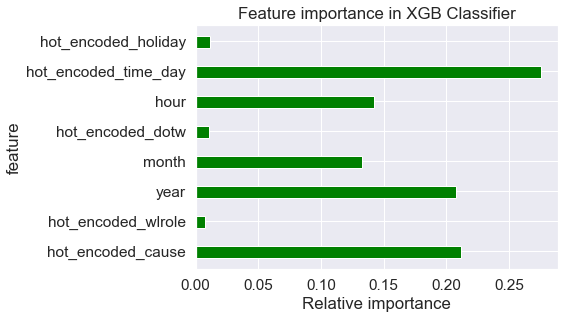

<Figure size 360x360 with 0 Axes>

In [279]:
Y = xgb2.feature_importances_
#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(Y)) # the x locations for the groups
ax.barh(ind, Y, width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(X.columns, minor=False)
plt.title('Feature importance in XGB Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

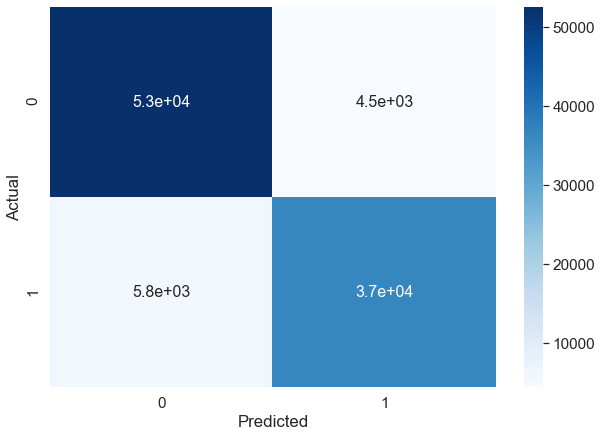

In [235]:
data = confusion_matrix(y_test2, xgb2.predict(X_test2))
df_cm = pd.DataFrame(data, columns=np.unique(y_test2), index = np.unique(y_test2))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [244]:
precision = precision_score(y_test2, xgb2.predict(X_test2))

In [245]:
precision

0.8917059652875686

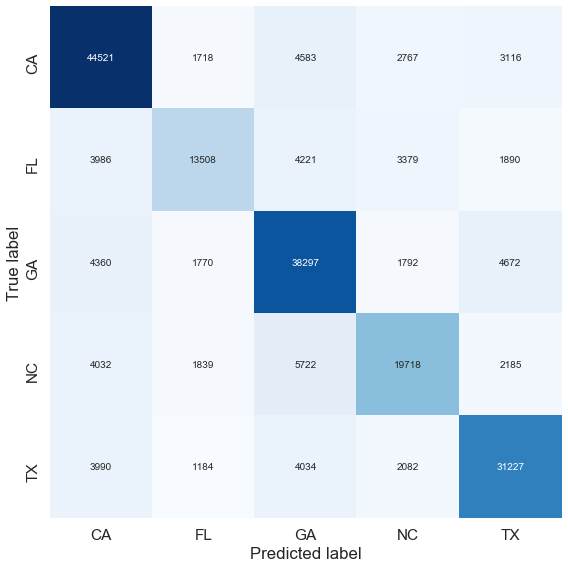

In [284]:
label_names = sorted(df2['STATE'].unique())

matrix = confusion_matrix(y_test2, pred_xgb2)
plt.figure(figsize=(8,8))
sns.heatmap(matrix,square=True,annot=True, fmt='d', cbar=False, cmap='Blues',
          xticklabels=label_names,yticklabels=label_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [285]:
# df5 = df_merged.sample(5000).copy()
df5 = df2[(df2.STATE == "TX") | (df2.STATE == "CA") | (df2.STATE == "GA") | (df2.STATE == "NC") | (df2.STATE == "FL")].sample(10000).copy()
sf_heatmap = folium.Map(
    location=[30.266666, -97.733330],
    tiles='Stamen Terrain',
    zoom_start=12
)

sf_coords = ([37.7941, -122.4078], [37.7785, -122.4056], [37.7847, -122.4145],
             [37.7816, -122.4156], [37.7607, -122.4680],
             [37.7219, -122.4782], [37.7599, -122.4148],
             [37.7946, -122.3999], [37.7304, -122.3844])

sf_neighborhoods = ('Chinatown', 'South of Market', 'Tenderloin', 
                    'Civic Center', 'Inner Sunset', 
                    'San Francisco State University', 'Mission', 
                    'Financial District', 'Hunter\'s Point')

def folium_popup(coords, neighborhood_names, folium_map):
    """
    The folium_popup() function creates popups for specific
    locations on a map. It uses a vector of coordinates along
    with a vector of strings to create these inside the Folium
    package.
    input: coords, neighborhood_names, folium_map; these are the
    longitude/latitude, neighborhood names, and the heatmap itself
    output: N/A, the function applies a setting to the heatmap
    without directly outputting an object
    """
    tooltip = 'Click me!'
    for i in range(len(neighborhood_names)):
        folium.Marker([coords[i][0], coords[i][1]], 
                      popup='<i>' + neighborhood_names[i] +
                      '</i>', tooltip=tooltip).add_to(folium_map)

folium_popup(coords=sf_coords, neighborhood_names=sf_neighborhoods, folium_map=sf_heatmap)

scatter = list(map(list, zip(df5.LATITUDE.astype(float), df5.LONGITUDE.astype(float))))

HeatMap(scatter).add_to(sf_heatmap)
sf_heatmap.save('sf_heatmap.html')
sf_heatmap